# Predicting Fraudulent Transactions for a Financial Company

As it is Binary Classification Problem
I will use Random Forest Classification.
I will implement Random Forest using sci-kit learn library, which comes with a handy tool called RandomForestClassifier.
RandomForestClassifier is supervised learning method that works on labelled dataset. It can be used on classification as well as Regression problem.
In Random Forest Classification, multiple decision trees are created using random subsets of data and features.
Each decision tree predicts the outcome independently and the final prediction is made based on the most popular decision among all the trees.

In [2]:
# importing essential libraries
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report 


In [3]:
# reading the dataset
df = pd.read_csv("C:\\Users\siddh\Downloads\Fraud.csv")

# Data-Preprocessing

Data preprocessing includes dealing with missing values, null values, outliers and multi-collinearity. We will be performing all the steps in the following code.

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
type('type')
type('nameOrig')
type('nameDest')

str

### Selecting the attributes for training the model.

As the columns ['type', 'nameOrig' and 'nameDest'] are of type string and not numerical, we can't use them in our prediction model. Machine learning models need numerical data to work, but we can convert 'string' into numbers using methods like hash encoding or one-hot encoding. However, features like payment type, sender's account number, and receiver's account number don't provide significant information for predicting fraud in transactions. Also 'step' is a unit of time which is also insignificant in our prediction model. Therefore, we will drop these attributes from our prediction model.

In [6]:
# Dropping the insignificant attributes
df = df.drop(['step', 'type', 'nameOrig', 'nameDest'], axis = 1)

In [7]:
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,181.00,181.0,0.00,0.0,0.0,1,0
3,181.00,181.0,0.00,21182.0,0.0,1,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0


Now we can start checking the data for null or missing values.

In [8]:
df.isnull().sum()

amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

As there are no null values in the data, we don't have to worry about dealing wiht the missing values

Let's take a look on total number of fraud transaction and non_fraud transaction

In [9]:
df['isFraud'].sum()

8213

As there are only 8,213 fraud transactions in the dataset, the remaining 6,354,407 transactions are non-fraudulent. This makes the dataset highly unbalanced and will also take a lot of time to train. If we proceed without addressing this issue, our model will underfit, as there is not enough fraud transaction data for the model to learn effectively. We could balance the dataset by sampling the fraud transactions again, but that would require a significant amount of time. Therefore, we will be dropping the majority of the dataset and only keeping around 12,000 non-fraud transactions. By doing this, the difference in the number of fraud and non-fraud transactions becomes very small, which is sufficient to train the model efficiently.


In [10]:
fraud_transactions = df[df['isFraud'] == 1] # contains fraud transactions
non_fraud_transactions = df[df['isFraud'] == 0] # contains non_fraud trasactions

In [11]:
# Selecting 12000 non_fraud_transactions from the dataset randomly
sampled_non_fraud_transactions = non_fraud_transactions.sample(n=12000, random_state=42)

In [12]:
# Merging the Datasets together
balanced_df = pd.concat([fraud_transactions, sampled_non_fraud_transactions])

In [13]:
balanced_df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,181.00,181.0,0.00,0.00,0.00,1,0
3,181.00,181.0,0.00,21182.00,0.00,1,0
251,2806.00,2806.0,0.00,0.00,0.00,1,0
252,2806.00,2806.0,0.00,26202.00,0.00,1,0
680,20128.00,20128.0,0.00,0.00,0.00,1,0
...,...,...,...,...,...,...,...
5630124,37872.87,71633.0,33760.13,0.00,0.00,0,0
3235276,199872.42,0.0,0.00,1294276.09,1789964.75,0,0
3481364,91048.02,103635.0,194683.02,25413.73,0.00,0,0
5058192,522743.18,0.0,0.00,964060.42,1486803.60,0,0


Now that we are left with only significant attributes and amount of data, we can start thinking about adding important attributes (if there are any). From my point of view, we can add two new attributes, i.e., the difference between the balances of the sender and receiver before and after the transaction. Therefore, I will be adding two new attributes named 'balDiffOri' and 'balDiffDest,' which will represent the balance difference of the sender and receiver, respectively.

In [14]:
# Adding 2 new attributes named "balDiffOri" and "balDiffDest"
balanced_df['balDiffOri'] = balanced_df['newbalanceOrig'] - balanced_df['oldbalanceOrg']
balanced_df['balDiffDest'] = balanced_df['newbalanceDest'] - balanced_df['oldbalanceDest']


In [15]:
balanced_df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balDiffOri,balDiffDest
2,181.0,181.0,0.0,0.0,0.0,1,0,-181.0,0.0
3,181.0,181.0,0.0,21182.0,0.0,1,0,-181.0,-21182.0
251,2806.0,2806.0,0.0,0.0,0.0,1,0,-2806.0,0.0
252,2806.0,2806.0,0.0,26202.0,0.0,1,0,-2806.0,-26202.0
680,20128.0,20128.0,0.0,0.0,0.0,1,0,-20128.0,0.0


In [16]:
# Reordering the data so that target attribute is in the last columns
new_order = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'balDiffOri', 'balDiffDest', 'isFraud', 'isFlaggedFraud']

In [17]:
balanced_df = balanced_df[new_order]

In [18]:
balanced_df.head() # balanced_df with the required order of attributes

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,balDiffOri,balDiffDest,isFraud,isFlaggedFraud
2,181.0,181.0,0.0,0.0,0.0,-181.0,0.0,1,0
3,181.0,181.0,0.0,21182.0,0.0,-181.0,-21182.0,1,0
251,2806.0,2806.0,0.0,0.0,0.0,-2806.0,0.0,1,0
252,2806.0,2806.0,0.0,26202.0,0.0,-2806.0,-26202.0,1,0
680,20128.0,20128.0,0.0,0.0,0.0,-20128.0,0.0,1,0


# Selecting Dependent and Independent Variables

Since, we got rid of some attributes and added few for our case.
Now we can select Dependent variables also known as predictors and independent variable wich is also known as target vairable.

'isFraud' attribute is our target variable. So will store it in variable 'x'.

Other variables are predictors. So will store them in variable 'y'.

In [19]:
x = balanced_df.iloc[:,0:7]
print(x)

            amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2           181.00          181.0            0.00            0.00   
3           181.00          181.0            0.00        21182.00   
251        2806.00         2806.0            0.00            0.00   
252        2806.00         2806.0            0.00        26202.00   
680       20128.00        20128.0            0.00            0.00   
...            ...            ...             ...             ...   
5630124   37872.87        71633.0        33760.13            0.00   
3235276  199872.42            0.0            0.00      1294276.09   
3481364   91048.02       103635.0       194683.02        25413.73   
5058192  522743.18            0.0            0.00       964060.42   
1421466   24762.16        10403.0            0.00      1559532.72   

         newbalanceDest  balDiffOri  balDiffDest  
2                  0.00     -181.00         0.00  
3                  0.00     -181.00    -21182.00  
251               

In [20]:
y = balanced_df.iloc[:, 7]
y

2          1
3          1
251        1
252        1
680        1
          ..
5630124    0
3235276    0
3481364    0
5058192    0
1421466    0
Name: isFraud, Length: 20213, dtype: int64

# Splitting the dataset into training and testing parts for training and validation purposes.

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split( x , y , test_size = 0.3, random_state = 0) # splitting the dataset into 70-30 rario

# Initialising the RandomForestClassifier

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 15) # n_estimators refers to number of trees, max_depth refers to maximum depth of the tree and random_state refers to randomness. 
model.fit(X_train, Y_train) # Fitiing the model on the data

RandomForestClassifier(max_depth=15, random_state=42)

In [23]:
y_pred = model.predict(X_test) # Predicting the fraud_transaction on test dataset.

# Estimating the Performance of the model using accuracy, precision and recall

In [24]:
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9909300791556728
Precision: 0.9812898089171974
Recall: 0.9967650626769107


# Hyper Parameter Tuning

Using 'RandomizedSearchCV,' we can provide it with a number of different combinations. It will try all the combinations and provide output with the best parameters possible from the provided list of parameters.

In [25]:
parameters = {'n_estimators': [10, 50, 100, 200],
              'max_depth': [2, 5, 9, 15]}

rf = RandomForestClassifier()

fine_model = RandomizedSearchCV(rf, 
                                 param_distributions = parameters, 
                                 n_iter=5, 
                                 cv=5)

fine_model.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [2, 5, 9, 15],
                                        'n_estimators': [10, 50, 100, 200]})

In [26]:
best_model = fine_model.best_estimator_ # it contains the best combination of parameters

print('Best hyperparameters:',  fine_model.best_params_) # we get the best parameter combination

Best hyperparameters: {'n_estimators': 200, 'max_depth': 15}


## Estimating performance of best model from hyper parameter tuning using confusion matrix

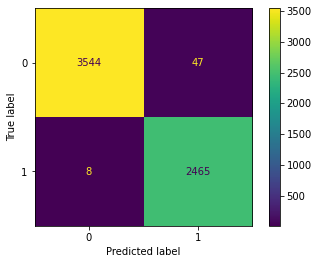

In [27]:
y_pred = best_model.predict(X_test) #getting the output with best parameters

cm = confusion_matrix(Y_test, y_pred) #getting the confusion matrix for best parameters

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Plotting features importances from the model using columns names

This bar graph explains the key factors that predict the fradulent customers. 
As we can observe from the bar graph difference between before and after the transaction of the Sender plays an important role in predicting the fraud transaction. Right after old balance of sender and amount of transaction.

These factors makes sense, as for most of fraud transaction difference is 0, which means that all the money from the account has been debited and the customer is left with 0 balance.

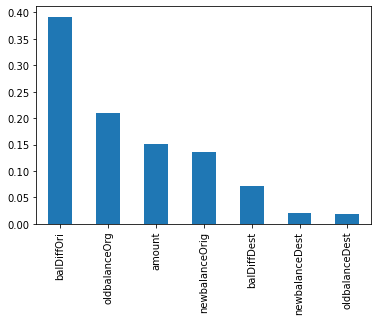

In [29]:
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar();

# Preventions

Companies should not allow their customers to withdraw or debit their entire amount at once, as it can be used by fraudulent individuals to empty the accounts of other customers. Instead, they should keep some amount on hold for safety measures. They can also restrict large transactions at once for users who do not typically make big transactions. 

After these methods are implemented, we can continue analyzing the transactions and monitor the number of fraudulent transactions in a fixed amount of time, comparing it with the number of fraudulent transactions before the preventive measures were implemented.